In [5]:
import numpy as np
import os
import sys
import pickle
import json
import glob
import json
from pathlib import Path
import cv2
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import seaborn as sns
from collections import defaultdict

image_root = Path("/mnt/hdd01/img_data/DAVIS/2017/DAVIS/JPEGImages")
annotation_root = Path("/mnt/hdd01/img_data/DAVIS/2017/DAVIS/Annotations")

file_names = sorted(list(Path("/mnt/hdd01/img_data/DAVIS/2017/DAVIS/JPEGImages/again").glob("*")))

pix_values_dict = defaultdict(dict)

In [19]:
# blur detector
class ExtraFrame_Detector:
    def __init__(self, image_root, annotation_root):
        self.image_root = image_root
        self.annotation_root = annotation_root
    
    def get_annotation(self, name):
        with open(Path(self.annotation_root)/"again/{}/voc_multilabel.pkl".format(name), "rb") as f:
            annotation = pickle.load(f)
        return annotation
    
    def get_image_list(self, name):
        image_list = sorted(list((Path(self.image_root)/"again"/name).glob("0*.jpg")))
        return image_list
    
    def get_mask_list(self, name):
        mask_list = sorted(list((Path(self.annotation_root)/"again"/name).glob("0*.png")))
        return mask_list
    
    def get_annotation_list(self, name):
        mask_list = sorted(list((Path(self.annotation_root)/"again"/name).glob("0*.png")))
        return mask_list
    
    
    def clop_image(self, image, annotation, frame_idx, object_idx):
        x1, y1, x2, y2 = annotation[frame_idx]["box"][object_idx]
        image = image[int(y1):int(y2), int(x1):int(x2)]
        return image

    
    def get_sobel_du(self, img, ksize):
        dx = cv2.Sobel(img, cv2.CV_64F, 1, 0, ksize=ksize)
        dy = cv2.Sobel(img, cv2.CV_64F, 0, 1, ksize=ksize)
        return dx, dy
    
    def get_laplacian_du(self, img, ksize):
        du = cv2.Laplacian(img, cv2.CV_64F, ksize=ksize)
        return du
    
    def get_canny_du(self, img, thresh1, thresh2):
        du = cv2.Canny(img, 100, 200)
        return du
    
    def get_TotalVariation(self, img, n=1, kernel_size=3, thresh1=100, thresh2=200, filter_method="sobel"):
        assert img.ndim == 2
        cvt_img = img.copy()
#         sobel_dx = cv2.Sobel(cvt_img, cv2.CV_8U, 1, 0, ksize=kernel_size
        if filter_method == "sobel":
            dx, dy = self.get_sobel_du(img, kernel_size)
            if n == 1:
                TV = (np.abs(dx) + np.abs(dy)).sum()
            elif n == 2:
                TV = np.sqrt(dx*dx+dy*dy).sum()
        
        elif filter_method == "laplacian":
            du = self.get_laplacian_du(img, kernel_size)
            if n == 1:
                TV = np.abs(du).sum()
            elif n == 2:
                TV = np.sqrt(du*du).sum()
        
        elif filter_method == "canny":
            du = self.get_canny_du(img, thresh1, thresh2)
            if n == 1:
                TV = np.abs(du).sum()
            elif n == 2:
                TV = np.sqrt(du*du).sum()
                
#         elif filter_method == "GAP":
        
        return TV
    
    
    def TV_flow(self, name, object_idx, n, kernel_size, filter_method, thresh1=100, thresh2=200, d_thresh=0.1):
        annotation = self.get_annotation(name)
        image_list = self.get_image_list(name)
        annotation_list = self.get_annotation_list(name)
        TVs = list()
        for i in range(len(image_list)):
            img = self.clop_image(cv2.imread(str(image_list[i]), 0), annotation, frame_idx=i, object_idx=object_idx)
            if img.shape == (0,0):
                TVs.append(0)
                continue
            TV = self.get_TotalVariation(img, n, kernel_size, thresh1, thresh2, filter_method)
            TVs.append(TV)

        TVs = np.array(TVs)
        TVs = TVs / TVs.max()
        plt.figure(figsize=(8,5))
        plt.plot(TVs, label="Total Variation")
        plt.ylabel("total variation (normalized)")
        plt.legend()

        d = list()
        d_idx = list()
#         one_dim_filter = np.array([-2, 0, 2])
#         for i in range(len(TVs)-2):
        one_dim_filter = np.array([-1, 1])
        for i in range(1, len(TVs)):
            d_idx.append(i)
            d.append((one_dim_filter * TVs[i-1:i+1]).sum())
        d = np.array(d)
        plt.plot(d_idx, d, label="diff")
        plt.title(filter_method)
        plt.legend()
        plt.grid()
        plt.hlines(0.0, 0, len(d))
        plt.show()
                
#         blur_frames = np.where(d > d_thresh)[0] 
        blur_frames = (np.array(d_idx)[np.where(d < -d_thresh)[0]])
        print(blur_frames)
        return TVs, d, d_idx
    
    def iou(self, box, mask_area, eps=1e-5):
        if box.ndim != 1:
            box = box.reshape(-1)
        box_area = (box[2]-box[0])*(box[3]-box[1])
        return mask_area / (box_area+eps)

    
    def get_IoU(self, img, annotation, frame_idx, object_idx, name, pix_value):
        plt.imshow(img)
        plt.show()
        if pix_value is None:
            print(np.unique(img))
            pix_value = int(input())
            pix_values_dict[name][object_idx] = pix_value
        mask_area = (img == pix_value).sum()
        return self.iou(annotation[frame_idx]["box"][object_idx], mask_area), pix_value
    
    
    def occlusion(self, name, object_idx):
        annotation = self.get_annotation(name)
        mask_list = self.get_mask_list(name)
        annotation_list = self.get_annotation_list(name)
        IoUs = list()
        pix_value = None
        for i in range(len(mask_list)):
            img = self.clop_image(cv2.imread(str(mask_list[i]), 0), annotation, frame_idx=i, object_idx=object_idx)
            if img.shape == (0,0):
                IoUs.append(0)
                continue
            IoU, pix_value = self.get_IoU(img, annotation, i, object_idx, name, pix_value)
            IoUs.append(IoU)
        return IoUs

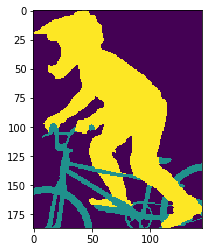

[ 0 38 75]


 75


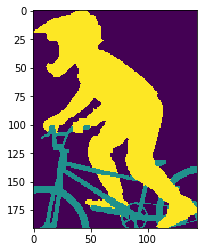

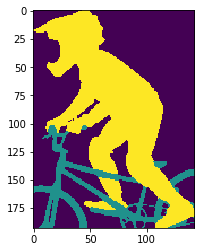

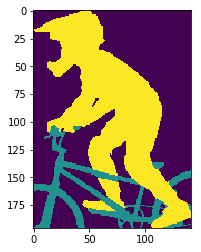

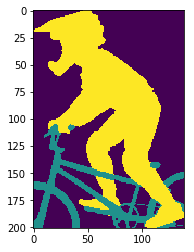

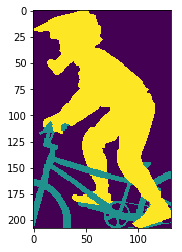

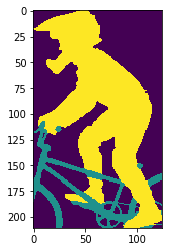

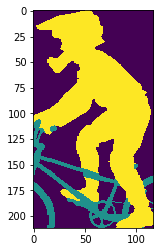

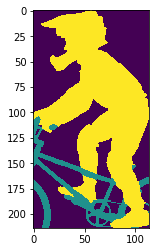

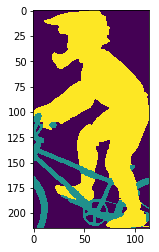

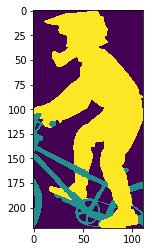

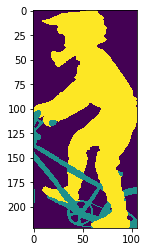

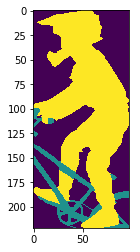

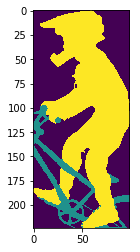

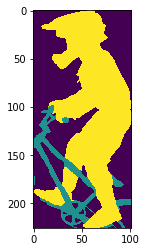

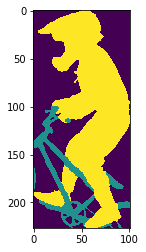

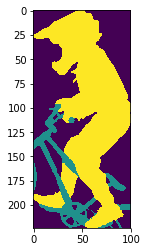

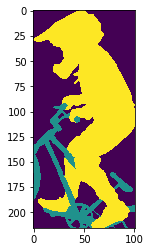

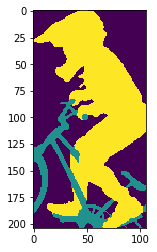

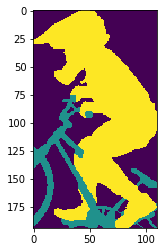

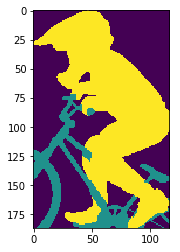

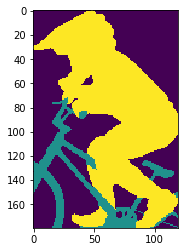

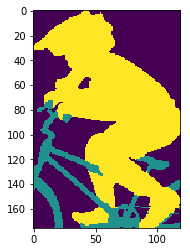

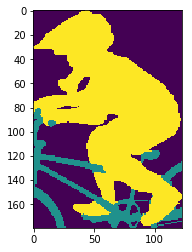

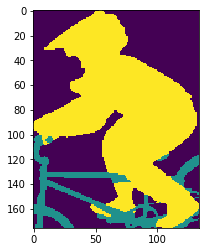

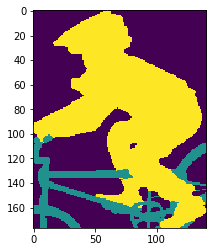

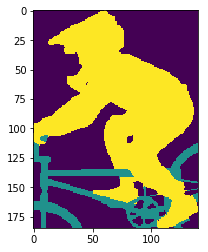

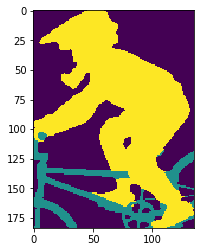

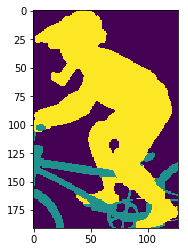

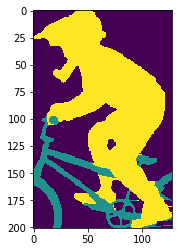

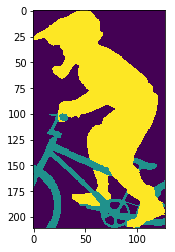

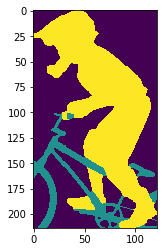

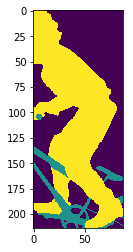

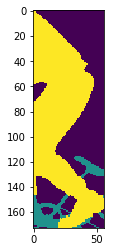

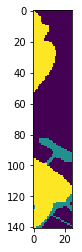

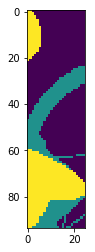

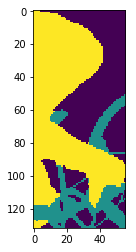

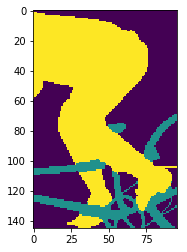

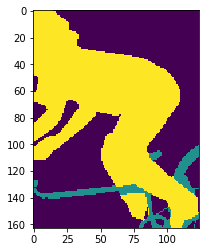

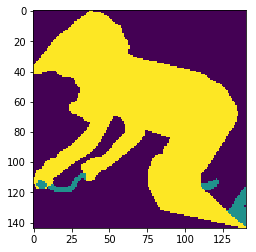

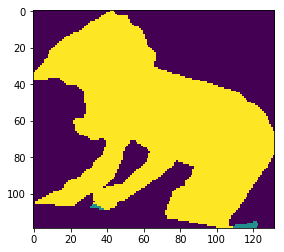

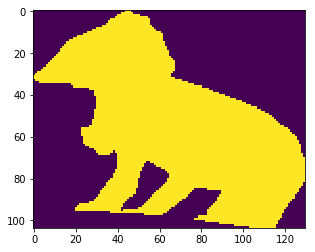

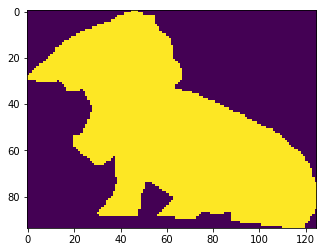

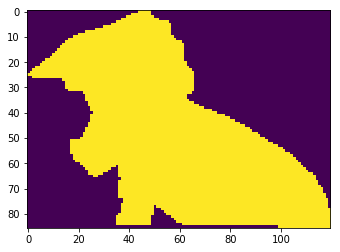

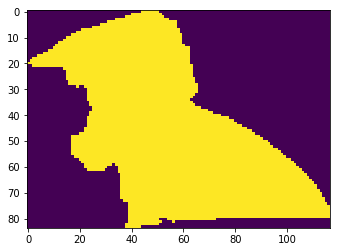

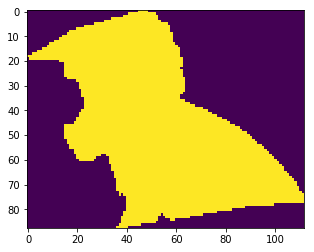

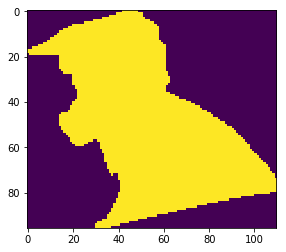

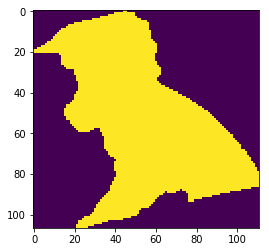

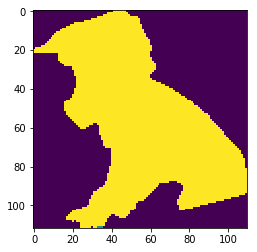

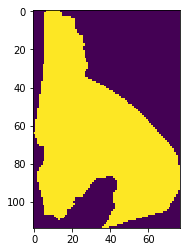

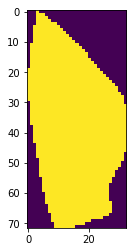

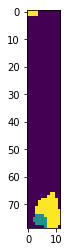

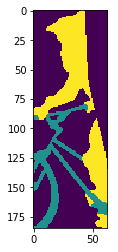

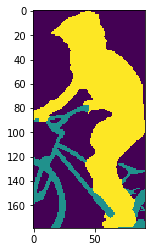

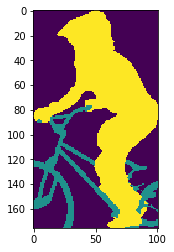

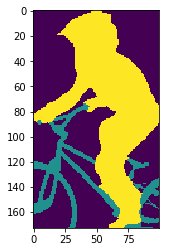

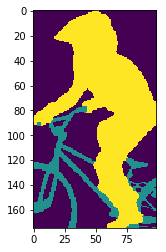

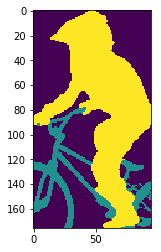

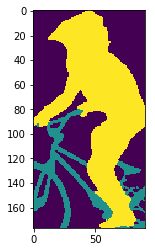

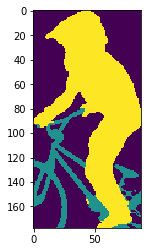

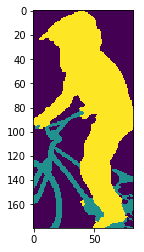

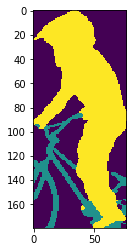

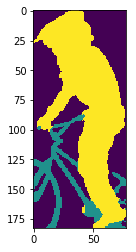

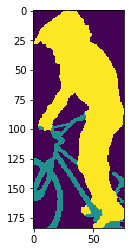

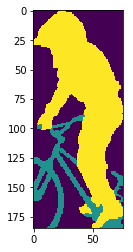

In [20]:
detector = ExtraFrame_Detector(image_root, annotation_root)
IoUs = detector.occlusion("bmx-bumps", object_idx=1)


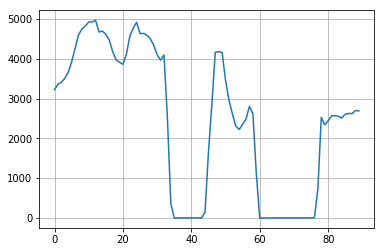

In [18]:
plt.plot(IoUs)
plt.grid()

In [21]:
pix_values_dict

defaultdict(dict, {'bmx-bumps': {0: 38, 1: 75}})

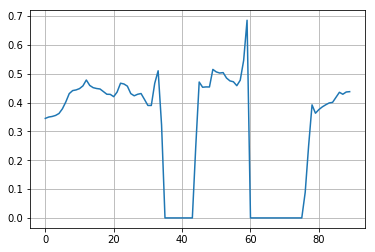

In [22]:
plt.plot(IoUs)
plt.grid()

In [228]:
detector = ExtraFrame_Detector(image_root, annotation_root)
J = detector.get_mask_list("bmx-bumps")

img = cv2.imread(str(J[0]), 0)
cimg = detector.clop_image(img, an, 0, 1)

In [ ]:
an = detector.get_annotation("bmx-bumps")

[ 0 38 75]


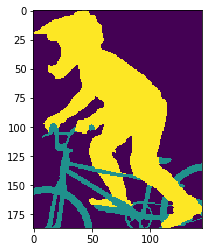

In [242]:
plt.imshow(cimg)
print(np.unique(cimg))

val = (cimg == 75).sum()

In [250]:
iou(an[0]["box"][1], val)

0.34493822594691564

In [122]:
for i, n in enumerate(file_names):
    print(i, n)

0 /mnt/hdd01/img_data/DAVIS/2017/DAVIS/JPEGImages/again/bike-packing
1 /mnt/hdd01/img_data/DAVIS/2017/DAVIS/JPEGImages/again/blackswan
2 /mnt/hdd01/img_data/DAVIS/2017/DAVIS/JPEGImages/again/bmx-bumps
3 /mnt/hdd01/img_data/DAVIS/2017/DAVIS/JPEGImages/again/bmx-trees
4 /mnt/hdd01/img_data/DAVIS/2017/DAVIS/JPEGImages/again/boat
5 /mnt/hdd01/img_data/DAVIS/2017/DAVIS/JPEGImages/again/boxing-fisheye
6 /mnt/hdd01/img_data/DAVIS/2017/DAVIS/JPEGImages/again/breakdance
7 /mnt/hdd01/img_data/DAVIS/2017/DAVIS/JPEGImages/again/breakdance-flare
8 /mnt/hdd01/img_data/DAVIS/2017/DAVIS/JPEGImages/again/bus
9 /mnt/hdd01/img_data/DAVIS/2017/DAVIS/JPEGImages/again/car-roundabout
10 /mnt/hdd01/img_data/DAVIS/2017/DAVIS/JPEGImages/again/car-shadow
11 /mnt/hdd01/img_data/DAVIS/2017/DAVIS/JPEGImages/again/car-turn
12 /mnt/hdd01/img_data/DAVIS/2017/DAVIS/JPEGImages/again/cat-girl
13 /mnt/hdd01/img_data/DAVIS/2017/DAVIS/JPEGImages/again/classic-car
14 /mnt/hdd01/img_data/DAVIS/2017/DAVIS/JPEGImages/again/cows

In [ ]:
# blur detection

object_idx = 0
n = 2
kernel_size = 5
d_thresh = 0.1

detector = ExtraFrame_Detector(image_root, annotation_root)
for fm in ["sobel", "laplacian", "canny"]:
    filter_method = fm
    TVs, d, d_idx = detector.TV_flow(file_names[20].name, object_idx, n, kernel_size, filter_method, thresh1=100, thresh2=200)
    print(np.array(d_idx)[np.where(d < -d_thresh)[0]])